In [10]:
#Packages
using DifferentialEquations
using PyPlot

In [11]:
#Experimental data
time_dong = [0, 5, 30, 60, 120]*60
kidney_dong_100 = [0, 1.326803, .75, .5, .25]
liver_dong_100 = [0, 64.3331574 ,80.1237696, 83.0615579 ,84.1632286]
spleen_dong_100 = [0 ,3.4820602 ,3.21158546 ,3.15035765 ,3.04021763]
heart_dong = 3.3389
lung_dong = 0.40230

0.4023

In [12]:
#Model Parameters
#Area of endothelial surface
A_i=[.0019956689, .0009621096822, .0033612343, .0045212562, .0004750356, .003333333, .003333333].*1000 #mouse dm^2 

#Binding Length Nanocarriers
l_NC_b  = (100*10^(-9)) # m

#Blood flow-rate in organs
Q_i=[74.83758415, 138.673326, 763.9168803, 284.6716878, 224.48828292, 333, 1000]./(60*10^6) #L/sec MOUSE

#Volume of blood in each organ
V_i_BL=[43.65525742 ,20.04395171 ,1018.55584 ,127.7673516 ,2.226207538 ,90 ,750]./10^6

#Volume of blood in organ tissue
V_i_T=[33.26114851 ,16.03516137 ,56.02057122 ,75.3542703 ,7.91726 ,20 ,1000]/10^6 #L MOUSE

#Volume of Vein
V_vein = 466.9/10^6 # mouse L
Q_hep = sum(Q_i[4:6]) #flow out of the liver
V_hep = sum(V_i_BL[4:6]) #total volume of blood passed thru liver
Q_vein = Q_i[3]+Q_hep+Q_i[7] #L/sec Mouse

4.3434614183666664e-5

In [13]:
#Procedure to determine Kon and Koff as a function of NP diameter
slope1 = (22-4)/(500-50)
slope2 = 3.9
slope = slope1*slope2
a = [4, 15, 50, 79, 100]
r = a/2
K_EC0=[1.23e42, 10.6565662, 41793.3924, 2.28e12, 7.74e21, 3.33e15, 3.33e15] #162
K_EC0 = log.(K_EC0)
K_EC = zeros(5, 7)
for i =1:7
    K_EC[1:4,i] = slope*r[1:4] .- slope*r[end] .+ K_EC0[i]
    K_EC[end, i] = K_EC0[i]
end
K_EC[:, 2] .= K_EC0[2]

Kb = 1.36e-23
T = 310
mu = 0.0037
l = 1e-7
r = r*1e-9
D=Kb*T./(6*pi*mu*r)
k_i_on = D./l^2
K_i_on = zeros(5, 7)
K_i_off = zeros(5, 7)
for i = 1:5
  K_i_on[i, :] .= k_i_on[i]
  K_i_off[i, :] = K_i_on[i]./K_EC[i, :]  
end

K_i_on = K_i_on[5, :]
K_i_off = K_i_off[5, :]
K_deg_vein = 1/6000

p = [2.0e-6 1.0 1.0; 2e-6 0.1 0.02; 0.0004 0.0033 0.02; 5.0e-6 0.005 0.02; 2e-5 0.08 0.014; 3.3e-5 0.01 0.02; 3.3e-5 0.01 0.02]
#Rate of Degredation of NP in each organ
K_i_deg = p[:, 1]
#Rate of uptake of NP in each organ
K_i_up = p[:, 2]
#Rate of non specific uptake of NP in each organ
K_NS= p[:, 3]

7-element Vector{Float64}:
 1.0
 0.02
 0.02
 0.02
 0.014
 0.02
 0.02

In [14]:
#ODEs
function func!(dydt, y, p, t)
  #Vein  
  dydt[1] = (Q_i[3]*y[5]/V_i_BL[3] + Q_hep*y[6]/V_i_BL[4] + Q_i[7]*y[9]/V_i_BL[7] - Q_vein*y[1]/V_vein - y[1]*K_deg_vein) # with degradation: 
  
  # Artery 
  dydt[2] = (Q_vein*y[4]/V_i_BL[2]-(Q_i[3]*y[2] + Q_i[4]*y[2]+ Q_i[5]*y[2] + Q_i[6]*y[2] + Q_i[7]*y[2])/V_vein - y[2]*K_deg_vein) # 

  # Lung Vas
  dydt[3] = (Q_i[1]*y[4]/V_i_BL[2] - Q_i[1]*y[3]/V_i_BL[1]-K_i_on[1]*y[3]+K_i_off[1]*y[10]-K_NS[1]*y[3]-y[3]*K_i_deg[1])

  # Heart Vas
  dydt[4] = (Q_vein*y[1]/V_vein + Q_i[1]*y[3]/V_i_BL[1]- (Q_i[1]*y[4] + Q_vein*y[4])/V_i_BL[2] - K_i_on[2]*y[4] + K_i_off[2]*y[11]-K_NS[2]*y[4]-y[4]*K_i_deg[2])

  #Kidney Vas
  dydt[5] = (Q_i[3]*y[2]/V_vein - Q_i[3]*y[5]/V_i_BL[3] - K_i_on[3]*y[5]+K_i_off[3]*y[12]-K_NS[3]*y[5]-y[5]*K_i_deg[3])

  #Liver Vas
  dydt[6] = ((Q_i[5]*y[7]/V_i_BL[5] + Q_i[6]*y[8]/V_i_BL[6] + Q_i[4]*y[2]/V_vein - Q_hep*y[6]/V_i_BL[4] ) - K_i_on[4]*y[6] + K_i_off[4]*y[13] - K_NS[4]*y[6] - y[6]*K_i_deg[4])

  #Spleen Vas
  dydt[7] = (Q_i[5]*y[2]/V_vein - Q_i[5]*y[7]/V_i_BL[5]-K_i_on[5]*y[7]+K_i_off[5]*y[14]-K_NS[5]*y[7]-y[7]*K_i_deg[5])

  # Gut Vas
  dydt[8] = (Q_i[6]*y[2]/V_vein - Q_i[6]*y[8]/V_i_BL[6]-K_i_on[6]*y[8]+K_i_off[6]*y[15]-K_NS[6]*y[8]-y[8]*K_i_deg[6])

  # Others Vas
  dydt[9] = (Q_i[7]*y[2]/V_vein - Q_i[7]*y[9]/V_i_BL[7]-K_i_on[7]*y[9]+K_i_off[7]*y[16]-K_NS[7]*y[9]-y[9]*K_i_deg[7])
  
  # --------------- NP bound to Endothelial cell layer ---------------- #
  dydt[10:16] = (-K_i_up.*y[10:16]+K_i_on.*y[3:9]-K_i_off.*y[10:16]-y[10:16].*K_i_deg[:])

  # --------------------- NP in tissue of each organ -------------------- #
  dydt[17:23] = (K_i_up.*y[10:16] + K_NS.*y[3:9]-K_i_deg[:].*y[17:23])
  
  #Collecting all the degredation terms for mass conservation  
  dydt[24] = (y[1]+y[2])*K_deg_vein + sum((y[3:9]+y[10:16]+y[17:23]).*K_i_deg[:])
end

func! (generic function with 1 method)

In [15]:
#Solving the System of ODEs
y0=[1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0]
tspan = (0.0, 1e4)
prob = ODEProblem(func!, y0, tspan)
sol_ub = solve(prob, RadauIIA5(), reltol=1e-10, abstol=1e-10)

retcode: Success
Interpolation: 3rd order Hermite
t: 181-element Vector{Float64}:
     0.0
     0.00031395104272342064
     0.00259652476415948
     0.0052021970311165785
     0.008260358329035891
     0.012418788040709419
     0.015088554658626964
     0.019044237849013337
     0.024052702290174283
     0.030508266939087952
     0.03892096284851807
     0.05075956164528143
     0.06961897700531681
     ⋮
  5575.571037758392
  5930.1664626338215
  6310.7735041809165
  6706.032920740493
  7117.178142848898
  7545.530054437156
  7992.579144237958
  8439.628234038759
  8928.519758043385
  9441.696159881483
  9981.820119595473
 10000.0
u: 181-element Vector{Vector{Float64}}:
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.9999707419721733, 9.808282294194805e-9, 2.780921387334922e-10, 2.865121347160966e-5, 2.7814791439955873e-14, 1.0366121594142288e-14, 8.172682648257893e-15, 1.2124678116574076e-14, 3.641055709638393e-14, 3.540421

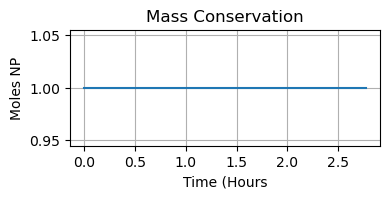

In [19]:
#Plot for mass consevation
mass = sum(sol_ub, dims=1)
mass = vec(mass)
mass = round.(mass)
f = figure()
f.set_figwidth(4)
f.set_figheight(1.5)
plot(sol_ub.t/3600, mass)
PyPlot.title("Mass Conservation")
xlabel("Time (Hours")
ylabel("Moles NP")
grid()

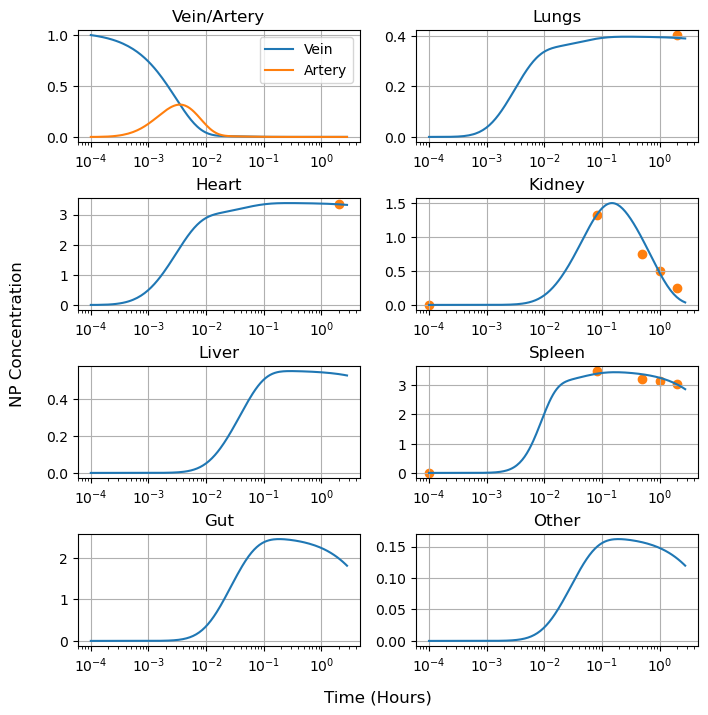

In [17]:
fig = figure(figsize=(8,8))
fig.text(0.5, 0.04, "Time (Hours)", ha="center",fontsize=12)
fig.text(0.04, 0.5, "NP Concentration", va="center", rotation="vertical",fontsize=12)
subplots_adjust(hspace=0.5) # Set the vertical spacing between axes

subplot(421) # Create the 1st axis of a 3x1 array of axes
ax1 = gca()
ax1.set_xscale("log") # Set the x axis to a logarithmic scale
ax1.plot(0.0001.+sol_ub.t./3600, sol_ub[1:2, :]')
ax1.set_title("Vein/Artery")
ax1.legend(["Vein", "Artery"])
grid()

subplot(422) # Create the 1st axis of a 3x1 array of axes
ax2 = gca()
ax2.set_xscale("log") # Set the x axis to a logarithmic scale
ax2.plot(0.0001.+sol_ub.t./3600, sol_ub[17, :]*V_vein/V_i_T[1])
ax2.scatter([float(time_dong[end])]/3600, [lung_dong],color = "#ff7f0e")
ax2.set_title("Lungs")
grid()

subplot(423) # Create the 1st axis of a 3x1 array of axes
ax3 = gca()
ax3.set_xscale("log") # Set the x axis to a logarithmic scale
ax3.plot(0.0001.+sol_ub.t./3600, sol_ub[18, :]*V_vein/V_i_T[2])
ax3.scatter([float(time_dong[end])]/3600, [heart_dong],c="#ff7f0e")
ax3.set_title("Heart")
grid()

subplot(424) # Create the 1st axis of a 3x1 array of axes
ax4 = gca()
ax4.set_xscale("log") # Set the x axis to a logarithmic scale
ax4.plot(0.0001.+sol_ub.t./3600, sol_ub[19, :]*V_vein/V_i_T[3])
ax4.scatter(0.0001.+float(time_dong)/3600, kidney_dong_100,c="#ff7f0e")
ax4.set_title("Kidney")
grid()

subplot(425) # Create the 1st axis of a 3x1 array of axes
ax5 = gca()
ax5.set_xscale("log") # Set the x axis to a logarithmic scale
ax5.plot(0.0001.+sol_ub.t./3600, (sol_ub[20, :])*V_vein/V_i_T[4])
ax5.set_title("Liver")
grid()

subplot(426) # Create the 1st axis of a 3x1 array of axes
ax6 = gca()
ax6.set_xscale("log") # Set the x axis to a logarithmic scale
ax6.plot(0.0001.+sol_ub.t./3600, sol_ub[21, :]*V_vein/V_i_T[5])
ax6.scatter(0.0001.+float(time_dong)/3600, spleen_dong_100,c="#ff7f0e")
ax6.set_title("Spleen")
grid()

subplot(427) # Create the 1st axis of a 3x1 array of axes
ax7 = gca()
ax7.set_xscale("log") # Set the x axis to a logarithmic scale
ax7.plot(0.0001.+sol_ub.t./3600, sol_ub[22, :]*V_vein/V_i_T[6])
ax7.set_title("Gut")
grid()

subplot(428) # Create the 1st axis of a 3x1 array of axes
ax8 = gca()
ax8.set_xscale("log") # Set the x axis to a logarithmic scale
ax8.plot(0.0001.+sol_ub.t./3600, sol_ub[23, :]*V_vein/V_i_T[7])
ax8.set_title("Other")
grid()